In [80]:
import json
from urllib.parse import urlencode
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests
from lxml import html

import pickle


In [2]:
def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}

    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(pd.DataFrame(d, columns=h))

Start by exploring combine data

In [24]:
params = {'LeagueID':'00',
          'Season':'2017-18',
          'IsOnlyCurrentSeason':'0'
         }
data = get_nba_data(endpt="commonallplayers",params=params)
data['PLAYER_NAME']=pd.Series(data['DISPLAY_FIRST_LAST'],dtype=str)+"("+pd.Series(data.FROM_YEAR,dtype=str)+")"
data = data.set_index('PLAYER_NAME')
data['PLAYER_ID']=data['PERSON_ID']
Player_ID_Dict = pd.Series(data['PLAYER_ID'],dtype=int)
Player_ID_Dict
Player_ID_Dict = Player_ID_Dict.loc[~Player_ID_Dict.index.duplicated(keep='first')]

pickle.dump(Player_ID_Dict, open('NBAPlayerDict.pkl', 'wb'))

In [25]:
year = "2012-13"
params = {"LeagueID":"00",
          "SeasonYear":year}
endpt = "draftcombinedrillresults"
df1 = get_nba_data(endpt=endpt,params=params)

In [26]:
endpt = "draftcombineplayeranthro"
df2 = get_nba_data(endpt=endpt,params=params)

In [27]:
year = "2013-14"
params = {"LeagueID":"00",
          "SeasonYear":year}
endpt = "draftcombinenonstationaryshooting"
df3 = get_nba_data(endpt=endpt,params=params)

In [28]:
df = pd.merge(df1,df2,on="PLAYER_ID")

Not looking like we'll have the shooting data very constitently. Lets merge two we have consitently and compile it over several years

In [35]:
dfCombineFull = pd.DataFrame(columns=df.columns)
for i in range(0,17):
    year="20"+format(i,'02d')+"-"+format(i+1,'02d')
    params.update({"SeasonYear":year})
    df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
    df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
    dfMerged = pd.merge(df1,df2,on="PLAYER_ID")

    if(i>13):
        dfMerged = pd.merge(df1,df2,on="TEMP_PLAYER_ID")
        dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME_x'] + "(" + year[0:4] + ")"
        dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
        dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)

    dfCombineFull = pd.concat([dfCombineFull,dfMerged])

In [36]:
dfCombineFull = dfCombineFull.set_index('PLAYER_ID')
dfCombineFull

,BENCH_PRESS,BODY_FAT_PCT,FIRST_NAME_x,FIRST_NAME_y,HAND_LENGTH,HAND_WIDTH,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,...,STANDING_REACH,STANDING_REACH_FT_IN,STANDING_VERTICAL_LEAP,TEMP_PLAYER_ID,TEMP_PLAYER_ID_x,TEMP_PLAYER_ID_y,THREE_QUARTER_SPRINT,WEIGHT,WINGSPAN,WINGSPAN_FT_IN
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
2124,13,None,Malik,Malik,None,None,80.25,6' 8.25'',None,None,...,109.0,9' 1'',25.5,NaN,None,None,3.38,271,86.50,7' 2.5''
12019,0,None,Harold,Harold,None,None,76.50,6' 4.5'',None,None,...,103.0,8' 7'',NaN,NaN,None,None,NaN,219,80.50,6' 8.5''
12020,10,None,Lamont,Lamont,None,None,80.50,6' 8.5'',None,None,...,108.0,9' 0'',28.0,NaN,None,None,3.40,235.5,87.50,7' 3.5''
12131,15,None,Mario,Mario,None,None,77.50,6' 5.5'',None,None,...,103.0,8' 7'',27.0,NaN,None,None,3.47,287,84.00,7' 0''
2056,NaN,None,Primoz,Primoz,None,None,84.75,7' 0.75'',None,None,...,110.0,9' 2'',26.0,NaN,None,None,3.55,243,86.00,7' 2''
2081,2,None,Ernest,Ernest,None,None,82.00,6' 10'',None,None,...,109.5,9' 1.5'',NaN,NaN,None,None,NaN,222.5,85.25,7' 1.25''
2049,6,None,Speedy,Speedy,None,None,70.50,5' 10.5'',None,None,...,94.5,7' 10.5'',36.0,NaN,None,None,3.06,166,72.00,6' 0''
12132,10,None,Eric,Eric,None,None,76.00,6' 4'',None,None,...,102.0,8' 6'',35.0,NaN,None,None,3.15,205,83.00,6' 11''
12133,1,None,Ed,Ed,None,None,72.25,6' 0.25'',None,None,...,96.5,8' 0.5'',26.5,NaN,None,None,3.24,189,76.00,6' 4''


In [9]:
endpt = 'playerdashptshotdefend'
params = {'DateFrom':'','DateTo':'','GameSegment':'',
          'LastNGames':'0','LeagueID':'00','Location':'',
          'Month':'0','OpponentTeamID':'0','Outcome':'',
          'Period':'0','PlayerID':'0','Season':year,
          'SeasonSemgent':'','SeasonType':'Regular Season',
          'TeamID':'0','VsConference':'','VsDivision':'',
          'PerMode':'Totals','SeasonSegment':''
         }
dfDefense = get_nba_data(endpt=endpt,params=params)
dfDefense[dfDefense.DEFENSE_CATEGORY=="Less Than 6 Ft"]


,CLOSE_DEF_PERSON_ID,GP,G,DEFENSE_CATEGORY,FREQ,D_FGM,D_FGA,D_FG_PCT,NORMAL_FG_PCT,PCT_PLUSMINUS
1452,101139,75,51,Less Than 6 Ft,0.201,60.0,92.0,0.652,0.622,0.030
1453,202703,69,66,Less Than 6 Ft,0.357,122.0,228.0,0.535,0.600,-0.065
1454,2749,74,56,Less Than 6 Ft,0.145,70.0,94.0,0.745,0.617,0.128
1455,203148,39,18,Less Than 6 Ft,0.205,19.0,26.0,0.731,0.587,0.144
1456,2730,74,72,Less Than 6 Ft,0.369,143.0,270.0,0.530,0.608,-0.079
1457,203925,51,46,Less Than 6 Ft,0.299,83.0,123.0,0.675,0.618,0.057
1458,201577,81,80,Less Than 6 Ft,0.498,328.0,618.0,0.531,0.612,-0.081
1459,202389,54,52,Less Than 6 Ft,0.406,120.0,215.0,0.558,0.603,-0.045
1460,2738,76,63,Less Than 6 Ft,0.281,101.0,162.0,0.623,0.606,0.018
1461,201936,40,33,Less Than 6 Ft,0.308,51.0,76.0,0.671,0.597,0.074


In [10]:
dfDefense = dfDefense[dfDefense.DEFENSE_CATEGORY=="Less Than 6 Ft"]
dfDefense = dfDefense.set_index("CLOSE_DEF_PERSON_ID")

In [11]:
dfDefense_PCT_Change = pd.DataFrame(dfDefense.PCT_PLUSMINUS)
dfDefense_PCT_Change

,PCT_PLUSMINUS
CLOSE_DEF_PERSON_ID,
101139,0.030
202703,-0.065
2749,0.128
203148,0.144
2730,-0.079
203925,0.057
201577,-0.081
202389,-0.045
2738,0.018


In [12]:
dfCombineFull = pd.merge(dfCombineFull,dfDefense_PCT_Change,left_index=True,right_index=True)

In [13]:
dfCombineFull.groupby('WINGSPAN')['PCT_PLUSMINUS'].mean()

WINGSPAN
70.00    0.357000
72.75    0.117000
73.75    0.139000
74.00    0.139000
74.25    0.270000
74.50    0.128000
74.75    0.095000
75.00    0.285000
75.25    0.129000
75.50    0.118500
76.00    0.136250
76.25    0.079000
76.50    0.096333
77.00   -0.050000
77.50    0.071750
77.75    0.100000
78.00    0.118000
78.25    0.020667
78.50    0.049000
78.75    0.103000
79.00   -0.082600
79.25    0.058875
79.50    0.133667
79.75    0.035800
80.00    0.056750
80.25    0.123000
80.50    0.429000
80.75    0.046000
81.00    0.043444
81.25    0.034750
           ...   
83.25    0.053125
83.50    0.033750
83.75   -0.083000
84.00   -0.000800
84.25   -0.009500
84.50    0.008000
84.75   -0.054667
85.00   -0.012667
85.25   -0.052714
85.50    0.018333
85.75    0.005000
86.00    0.010500
86.25    0.032500
86.50    0.009167
86.75   -0.005000
87.00   -0.020400
87.25   -0.016000
87.50   -0.028500
87.75   -0.068000
88.00   -0.052750
88.25   -0.061000
88.50   -0.005000
88.75   -0.070750
89.00   -0.005000
8

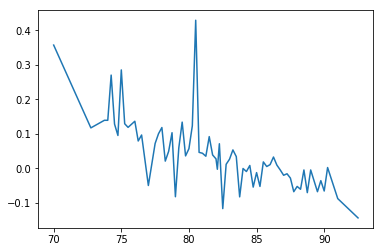

In [14]:
plt.plot(dfCombineFull.groupby('WINGSPAN')['PCT_PLUSMINUS'].mean())

In [15]:
bins = list(range(70,98,2))
dfCombineFull['Wingspan_binned']=pd.cut(dfCombineFull['WINGSPAN'],bins)

In [16]:
dfCombineFull['POSITION_SIMPLE']=np.NaN
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="C"]="Big"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="C-PF"]="Big"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF-C"]="Big"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF"]="Forward"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF-PF"]="Forward"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PF-SF"]="Forward"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF"]="Wing"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SF-SG"]="Wing"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG-SF"]="Wing"

dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PG-SG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="SG-PG"]="Guard"
dfCombineFull['POSITION_SIMPLE'][dfCombineFull.POSITION_y=="PG"]="Guard"




dfCombineFull.groupby(['POSITION_SIMPLE','Wingspan_binned'])['PCT_PLUSMINUS'].mean()


/home/dhoskins/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dhoskins/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dhoskins/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/dh

POSITION_SIMPLE  Wingspan_binned
Big              (80, 82]           0.023000
                 (82, 84]          -0.061333
                 (84, 86]          -0.032200
                 (86, 88]          -0.036889
                 (88, 90]          -0.049818
                 (90, 92]          -0.043000
                 (92, 94]          -0.144000
Forward          (80, 82]          -0.025000
                 (82, 84]          -0.000882
                 (84, 86]          -0.035600
                 (86, 88]          -0.005923
                 (88, 90]          -0.032200
Guard            (72, 74]           0.131667
                 (74, 76]           0.157929
                 (76, 78]           0.078500
                 (78, 80]           0.047552
                 (80, 82]           0.062000
                 (82, 84]           0.053167
Wing             (78, 80]           0.025250
                 (80, 82]           0.082556
                 (82, 84]           0.036278
                 (84, 

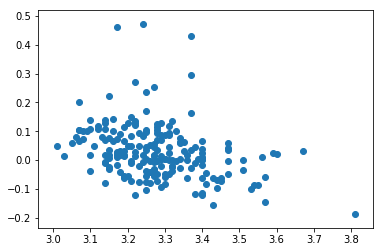

In [17]:
plt.scatter(dfCombineFull['THREE_QUARTER_SPRINT'],dfCombineFull['PCT_PLUSMINUS'])

In [18]:
dfCombineFull.columns

Index(['TEMP_PLAYER_ID_x', 'FIRST_NAME_x', 'LAST_NAME_x', 'PLAYER_NAME_x',
       'POSITION_x', 'STANDING_VERTICAL_LEAP', 'MAX_VERTICAL_LEAP',
       'LANE_AGILITY_TIME', 'MODIFIED_LANE_AGILITY_TIME',
       'THREE_QUARTER_SPRINT', 'BENCH_PRESS', 'TEMP_PLAYER_ID_y',
       'FIRST_NAME_y', 'LAST_NAME_y', 'PLAYER_NAME_y', 'POSITION_y',
       'HEIGHT_WO_SHOES', 'HEIGHT_WO_SHOES_FT_IN', 'HEIGHT_W_SHOES',
       'HEIGHT_W_SHOES_FT_IN', 'WEIGHT', 'WINGSPAN', 'WINGSPAN_FT_IN',
       'STANDING_REACH', 'STANDING_REACH_FT_IN', 'BODY_FAT_PCT', 'HAND_LENGTH',
       'HAND_WIDTH', 'PCT_PLUSMINUS', 'Wingspan_binned', 'POSITION_SIMPLE'],
      dtype='object')

Tomorrow we should work on a simple linear regression from this.
We should also start adding in college status
Need to do data from multiple years/figure out what we want to do regarding that
    averages over full career
    best year
    three years out?
    three year average?

In [34]:
year = 16
year="20"+format(i,'02d')+"-"+format(i+1,'02d')
params.update({"SeasonYear":year})
df1 = get_nba_data(endpt="draftcombinedrillresults",params=params)
df2 = get_nba_data(endpt="draftcombineplayeranthro",params=params)
if(i>13):
    dfMerged = pd.merge(df1,df2,on="TEMP_PLAYER_ID")
    
dfMerged['PLAYER_NAME'] = dfMerged['PLAYER_NAME_x'] + "(" + year[0:4] + ")"
dfMerged['PLAYER_ID']=dfMerged['PLAYER_NAME'].map(Player_ID_Dict)
dfMerged['PLAYER_ID']=pd.Series(dfMerged['PLAYER_ID'],dtype=str).str.split(".").str.get(0)


dfCombineFull = pd.concat([dfCombineFull,dfMerged])
dfMerged

,TEMP_PLAYER_ID,PLAYER_ID_x,FIRST_NAME_x,LAST_NAME_x,PLAYER_NAME_x,POSITION_x,STANDING_VERTICAL_LEAP,MAX_VERTICAL_LEAP,LANE_AGILITY_TIME,MODIFIED_LANE_AGILITY_TIME,...,WEIGHT,WINGSPAN,WINGSPAN_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,PLAYER_NAME,PLAYER_ID
0,16000,None,Ron,Baker,Ron Baker,SG,30.0,35.5,10.77,2.96,...,212.4,81.75,6' 9.75'',97.5,8' 1.5'',7.85,8.75,9.50,Ron Baker(2016),1627758
1,16001,None,Wade,Baldwin IV,Wade Baldwin IV,PG,32.5,38.0,10.45,3.01,...,201.8,83.25,6' 11.25'',100.0,8' 4'',5.20,9.00,9.75,Wade Baldwin IV(2016),1627735
2,16002,None,Cat,Barber,Cat Barber,PG,NaN,NaN,NaN,NaN,...,173,77.50,6' 5.5'',95.5,7' 11.5'',4.50,8.00,8.50,Cat Barber(2016),nan
3,16003,None,Malik,Beasley,Malik Beasley,SG,NaN,NaN,NaN,0.00,...,189.8,79.00,6' 7'',100.5,8' 4.5'',6.90,8.50,9.00,Malik Beasley(2016),1627736
4,16004,None,DeAndre,Bembry,DeAndre Bembry,SG-SF,32.0,38.0,10.90,2.87,...,206.6,81.25,6' 9.25'',101.0,8' 5'',7.00,8.00,9.25,DeAndre Bembry(2016),nan
5,16005,None,Ben,Bentil,Ben Bentil,PF,29.0,33.0,11.16,3.10,...,229.2,85.50,7' 1.5'',105.0,8' 9'',9.70,9.50,10.00,Ben Bentil(2016),1627791
6,16006,None,Jaron,Blossomgame,Jaron Blossomgame,SF,35.0,41.0,11.53,3.26,...,213.6,82.00,6' 10'',102.0,8' 6'',5.25,8.50,10.00,Jaron Blossomgame(2016),nan
7,16007,None,Joel,Bolomboy,Joel Bolomboy,PF,37.5,40.5,10.26,2.86,...,224.4,85.75,7' 1.75'',103.5,8' 7.5'',5.15,9.00,10.25,Joel Bolomboy(2016),1627762
8,16008,None,Malcolm,Brogdon,Malcolm Brogdon,SG,30.5,35.5,10.77,2.64,...,223,82.50,6' 10.5'',98.0,8' 2'',5.40,9.00,10.25,Malcolm Brogdon(2016),1627763
9,16009,None,Jaylen,Brown,Jaylen Brown,SG-SF,NaN,NaN,NaN,NaN,...,222.8,83.75,6' 11.75'',102.5,8' 6.5'',5.05,8.75,9.00,Jaylen Brown(2016),1627759


In [21]:
Player_ID_Dict = Player_ID_Dict.loc[~Player_ID_Dict.index.duplicated(keep='first')]

In [22]:
len(Player_ID_Dict)

4281

Going to start pulling college stats from bball ref but might get my IP banned which is less than ideal.

In [55]:
nameList = []
for player in dfCombineFull.index:
    nameStr = 'https://www.sports-reference.com/cbb/players/'
    
    nameStr += str(dfCombineFull.FIRST_NAME_x[player]).lower() +"-" + \
                str(dfCombineFull.LAST_NAME_x[player]).lower() + "-1.html"
    
    nameList.append(nameStr)

In [141]:
testCase = 'https://www.sports-reference.com/cbb/players/deandre-ayton-1.html'

In [306]:
data_url = 'https://www.sports-reference.com/cbb/players/malcolm-brogdon-1.html'
user_agent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""

headers = {'User-Agent':user_agent}
page = requests.get(data_url,headers=headers)
tree = html.fromstring(page.content)

In [361]:
x = tree.xpath('//div[@id="all_leaderboard"]')
n = len(str(x[0].getchildren()[-1]))

tree2 = html.fromstring(str(x[0].getchildren()[-1])[6:(n-3)])
tree2.xpath('//table/tr/td/a/text()')

['2014-15',
 'Consensus All-America',
 '2014-15',
 'USBWA Player of the Year Finalists',
 '2014-15',
 'Wooden Award - Finalists',
 '2014-15',
 'Wooden Award - Preseason',
 '2015-16',
 'Atlantic Coast Conference Player of the Year',
 '2015-16',
 'Consensus All-America',
 '2015-16',
 'NABC Defensive Player of the Year',
 '2015-16',
 'Naismith Award Finalists',
 '2015-16',
 'Naismith Award Semifinalists',
 '2015-16',
 'USBWA Player of the Year Finalists',
 '2015-16',
 'Wooden Award - Finalists',
 '2015-16',
 'Wooden Award - Late Season',
 '2015-16',
 'Wooden Award - Midseason',
 '2015-16',
 'Wooden Award - Preseason',
 '2013-14',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 '2014-15',
 'ACC',
 '2015-16',
 'ACC',
 '2013-14',
 'ACC',
 '2014-15',
 'ACC',
 '2015-16',
 'NCAA',
 '2015-16',
 'ACC',
 'ACC',
 '2013-14',
 'ACC',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',
 'ACC',
 '2015-16',


In [244]:
x = soup.find_all('td')

In [245]:
//*[@id="all_leaderboard"]

[<td class="left " data-stat="school_name"><a href="https://www.sports-reference.com/cbb/schools/arizona/2018.html">Arizona</a></td>,
 <td class="left " data-stat="conf_abbr"><a href="https://www.sports-reference.com/cbb/conferences/pac-12/2018.html">Pac-12</a></td>,
 <td class="right " data-stat="g">35</td>,
 <td class="right " data-stat="gs">35</td>,
 <td class="right " data-stat="mp">1172</td>,
 <td class="right " data-stat="fg_per_poss">13.7</td>,
 <td class="right " data-stat="fga_per_poss">22.4</td>,
 <td class="right " data-stat="fg_pct">.612</td>,
 <td class="right " data-stat="fg2_per_poss">13.1</td>,
 <td class="right " data-stat="fg2a_per_poss">20.7</td>,
 <td class="right " data-stat="fg2_pct">.635</td>,
 <td class="right " data-stat="fg3_per_poss">0.6</td>,
 <td class="right " data-stat="fg3a_per_poss">1.7</td>,
 <td class="right " data-stat="fg3_pct">.343</td>,
 <td class="right " data-stat="ft_per_poss">7.0</td>,
 <td class="right " data-stat="fta_per_poss">9.5</td>,
 <t